# Shipping Emission Final Code Set for Single Layer Model

## Imports and dataset cleanning to remove extrame values

In [1]:
import os
import string
import sys
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
sys.path.append("../code/.")
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
df_ml = pd.read_csv("./df_interp_ml.csv", low_memory=False)
df_ml.describe(include='all')

raw_data_num = df_ml.shape[0]
mean = df_ml['residual'].mean()
df_ml['residual'].mean()
std = df_ml['residual'].std()
outlier_condition = (df_ml['residual'] > mean + 3 * std) | (df_ml['residual'] < mean - 3 * std)
df_ml = df_ml[~outlier_condition]
print("cleaned %d samples, remain %d samples" % (df_ml.shape[0] - raw_data_num, df_ml.shape[0]))

cleaned -10 samples, remain 1285 samples


## First thoughts
We quickly checked the distribution of the data and found that the predicted value using IMO engineering approach has a bias that can be easily corrected by adding an correction factor to the intercept, which means we add the difference beween the mean value of log(total_.fc) and mean value of log(FC_sum) to every value of log(FC_sum).

[]

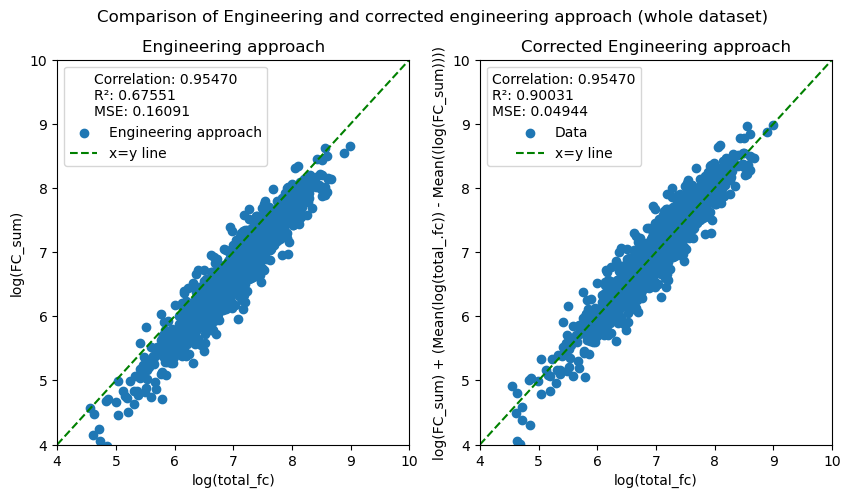

In [3]:
# Convert pandas series to numpy arrays
total_fc = df_ml['total.fc'].values
FC_sum = df_ml['FC_sum'].values / 1000000
# Calculate mean of log(total_fc) and log(FC_sum)
mean_log_total_fc = np.mean(np.log(total_fc))
mean_log_FC_sum = np.mean(np.log(FC_sum))

# Generate x values and fitted y values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Comparison of Engineering and corrected engineering approach (whole dataset)')
x_values = np.log(total_fc)

r_squared_eng = r2_score(x_values, np.log(FC_sum))

# Calculate correlation
correlation_eng = np.corrcoef(x_values, np.log(FC_sum))[0, 1]

# Calculate mean squared error
mse_eng = mean_squared_error(x_values, np.log(FC_sum))

# Create a scatter plot
ax1.set_xlim(4, 10)
ax1.set_ylim(4, 10)
ax1.scatter(x_values, np.log(FC_sum), label='Engineering approach')
# Plot x=y reference line
ax1.plot([4, 10], [4, 10], 'g--', label='x=y line')

# Set x and y labels
ax1.set_xlabel('log(total_fc)')
ax1.set_ylabel('log(FC_sum)')

# Set a title for the plot
ax1.set_title("Engineering approach")

# Add details in legend about correlation, r-squared and mean squared error
legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_eng, r_squared_eng, mse_eng)
ax1.legend(title=legend_title)

# Show the plot
ax1.plot()
corrected_residual = np.log(FC_sum) + (mean_log_total_fc - mean_log_FC_sum)
# Calculate R-squared
r_squared_corr = r2_score(np.log(total_fc), corrected_residual)

# Calculate correlation
correlation_corr = np.corrcoef(np.log(total_fc), corrected_residual)[0, 1]

# Calculate mean squared error
mse_corr = mean_squared_error(np.log(total_fc), corrected_residual)
# Create a scatter plot
ax2.set_xlim(4, 10)
ax2.set_ylim(4, 10)
ax2.scatter(np.log(total_fc), corrected_residual, label='Data')

# Plot x=y reference line
ax2.plot([4, 10], [4, 10], 'g--', label='x=y line')

# Set x and y labels
ax2.set_xlabel('log(total_fc)')
ax2.set_ylabel('log(FC_sum) + (Mean(log(total_.fc)) - Mean((log(FC_sum))))')

# Set a title for the plot
ax2.set_title("Corrected Engineering approach")

# Add details in legend about correlation, r-squared and mean squared error
legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_corr, r_squared_corr, mse_corr)
ax2.legend(title=legend_title)

# Show the plot
ax2.plot()

## Simple Model
First, we would like to establish a very simple and basic model as a banchmark. This model will be used to compare with the more complex models that is defined later to see if the complexity is worth it.

### Feature Engineering and selection
We manually selected the features that we think important for the shipping emission prediction based on data quality and domain knowledge. Numerical values are prefered since it requires less preprocessing and can be directly used in the model. 

In [2]:
ordinal_cols = ['Size.Category']
features = ['Draught..m.', 'HP.Total.Propulsion', 'Service.Speed..knots.', 'LOA..m.',
                        'Operational.Speed..knots.', 'NT', 'Ballast.Cap..cu.m.',
                        'Bale.Capacity..cu.m.', 'LBP..m.', 'Speed..knots.',
                        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', 'EU.distance',
                        'distance_sum', 'work_sum', 'trip_nunique',
                        'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
                        't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
                        'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum', 'age', "miss_pct_sea_",'Size.Category']

log_transform_cols = ['Draught..m.', 'HP.Total.Propulsion', 'Service.Speed..knots.', 'LOA..m.',
                        'Operational.Speed..knots.', 'NT', 'Ballast.Cap..cu.m.',
                        'Bale.Capacity..cu.m.', 'LBP..m.', 'Speed..knots.',
                        'West.Coast.Africa.Deployment..Time.in.Last.12.Months....', 'EU.distance',
                        'distance_sum', 'work_sum', 'trip_nunique',
                        'W_component_first', 'ME_W_ref_first', 't_m_times_v_n_sum',
                        't_over_t_ref_with_m_sum', 't_over_t_ref_without_m_sum',
                        'v_over_v_ref_with_n_sum', 'v_over_v_ref_without_n_sum', 'age', "miss_pct_sea_"]


median_imputer = SimpleImputer(strategy='median')

standard_scaler = StandardScaler()

log_transformer = FunctionTransformer(np.log1p, validate=True)
ordinal_transformer = make_pipeline(OrdinalEncoder(categories=[['Capesize', 'Panamax', 'Handymax', 'Handysize']]))


impute_and_transform = Pipeline(steps=[('imputer', median_imputer),
                                       ('log_transform', log_transformer)])

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('impute_and_transform', impute_and_transform, log_transform_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)])

preprocessor_trees = ColumnTransformer(
    transformers=[
        ('impute_and_transform', impute_and_transform, log_transform_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
        ])


We defined a simple function to quickly check the mean and std from cross validation.

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Hyperparameter Tuning
We preselected a few models (Linear and Non-linear Model) and used grid search to find the best hyperparameters. We also used cross validation to check the performance of the model.

In [6]:
results_var = ['total.fc', 'FC_sum']
X_train, X_test, y_train, y_test = train_test_split(df_ml, df_ml['residual'], test_size=0.3)

In [13]:
# Hyperparameter tuning for Ridge
from sklearn.linear_model import RidgeCV
model_ridge = RidgeCV(alphas=[0.1, 0.08, 0.05, 0.01, 0.008, 0.005, 0.001, 0.0001, 1, 10, 100, 1000, 10000, 100000])
pipe_ridge = make_pipeline(preprocessor_linear, model_ridge)

pipe_ridge.fit(X_train, y_train)

best_alpha = pipe_ridge.named_steps.ridgecv.alpha_
y_pred = pipe_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Mean squared error:", mse)
print("R-squared:", r2)

Best alpha: 0.05
Mean squared error: 0.01841913914232475
R-squared: 0.6585614179406629


In [17]:
# Hyperparameter tuning for Lasso
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas=[0.1, 0.01, 0.005, 0.001, 0.0008, 0.0005, 0.0001, 0.00008, 0.00005, 0.00001, 1, 10, 100, 1000, 10000, 100000], max_iter=100000)
pipe_lasso = make_pipeline(preprocessor_linear, model_lasso)

pipe_lasso.fit(X_train, y_train)

best_alpha = pipe_lasso.named_steps.lassocv.alpha_
y_pred = pipe_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Mean squared error:", mse)
print("R-squared:", r2)

Best alpha: 5e-05
Mean squared error: 0.018535939284487633
R-squared: 0.6563962746830834


In [21]:
# Hyperparameter tuning for CatBoostRegressor
param_grid_pipe_catboostregressor = {
    'catboostregressor__depth': [4, 6, 7, 8, 9 ,10],
    'catboostregressor__iterations': [10, 30, 50, 100, 500],
    'catboostregressor__l2_leaf_reg': [1, 5, 7, 9, 11, 15],
    'catboostregressor__learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'catboostregressor__depth': [4, 6, 7, 8, 9 ,10]
}

model_catboostregressor = CatBoostRegressor(verbose = 0)
pipe_catboostregressor = make_pipeline(preprocessor_trees, model_catboostregressor)

grid_search_catboostregressor = RandomizedSearchCV(pipe_catboostregressor, param_grid_pipe_catboostregressor, n_iter=30, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_catboostregressor.fit(X_train, y_train)

y_pred = grid_search_catboostregressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters for CatBoostRegressor is: {grid_search_catboostregressor.best_params_}")
print("Mean squared error:", mse)
print("R-squared:", r2)

Best parameters for CatBoostRegressor is: {'catboostregressor__learning_rate': 0.1, 'catboostregressor__l2_leaf_reg': 9, 'catboostregressor__iterations': 500, 'catboostregressor__depth': 6}
Mean squared error: 0.023940501576937372
R-squared: 0.5562110232700527


In [22]:
# Hyperparameter tuning for RandomForestRegressor
param_grid_randomforestregressor = {
        'randomforestregressor__n_estimators': [50, 100, 200, 300, 500, 700, 1000],
        'randomforestregressor__max_depth': [10, 20, 30, 40, 50, None],
}

model_randomforestregressor = RandomForestRegressor()
pipe_randomforestregressor = make_pipeline(preprocessor_trees, model_randomforestregressor)

grid_search_randomforestregressor =  GridSearchCV(pipe_randomforestregressor, param_grid_randomforestregressor, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_randomforestregressor.fit(X_train, y_train)

y_pred = grid_search_randomforestregressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters for RandomForestRegressor is: {grid_search_randomforestregressor.best_params_}")
print("Mean squared error:", mse)
print("R-squared:", r2)

Best parameters for CatBoostRegressor is: {'randomforestregressor__max_depth': 40, 'randomforestregressor__n_estimators': 1000}
Mean squared error: 0.0320294140860066
R-squared: 0.4062655347128691


In [24]:
# Hyperparameter tuning for KNN
param_grid_knn = {
        'kneighborsregressor__n_neighbors':[1,2,3,4,5,10,20,30,50,100],
        'kneighborsregressor__weights':['uniform','distance'],

}

model_knn = KNeighborsRegressor(n_jobs=-1)
pipe_knn = make_pipeline(preprocessor_linear, model_knn)

grid_search_knn =  GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

y_pred = grid_search_knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters for KNN is: {grid_search_knn.best_params_}")
print("Mean squared error:", mse)
print("R-squared:", r2)

Best parameters for KNN is: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__weights': 'distance'}
Mean squared error: 0.0439446344435871
R-squared: 0.1853911544076362


In [40]:
# Hyperparameter tuning for GredientBoostingRegressor
# 1. Fix learning rate and number of estimators for tuning tree-based parameters
param_grid_GBR_1 = {
        'regressor__n_estimators': range(20,100,10),
}

model_GBR_1 = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8, random_state=42)
pipe_GBR_1 = Pipeline([
    ('transformer', preprocessor_trees),  # Replace tree_transformer with your actual transformer
    ('regressor', model_GBR_1)
])

grid_search_GBR_1 = GridSearchCV(pipe_GBR_1, param_grid_GBR_1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_GBR_1.fit(X_train, y_train)

n_estimators = grid_search_GBR_1.best_params_['regressor__n_estimators']
print('n_estimators =',n_estimators)

n_estimators = 90


In [42]:
# 2. Tunning Tree specific parameters
# 2.1 Tune max_depth and num_samples_split
param_grid_GBR_2 = {
        'regressor__max_depth': range(1,20,2),
        'regressor__min_samples_split': range(2,1001,20)
}

model_GBR_2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=n_estimators, max_features='sqrt', subsample=0.8,random_state=42)
pipe_GBR_2 = Pipeline([
    ('transformer', preprocessor_trees),
    ('regressor', model_GBR_2)
])

grid_search_GBR_2 = GridSearchCV(pipe_GBR_2, param_grid_GBR_2, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_GBR_2.fit(X_train, y_train)
max_depth = grid_search_GBR_2.best_params_['regressor__max_depth']
min_samples_split = grid_search_GBR_2.best_params_['regressor__min_samples_split']

print('max_depth =',max_depth)
print('min_samples_split =',min_samples_split)

max_depth = 9
min_samples_split = 102


In [44]:
# 2.2 Tune min_samples_leaf and min_samples_split
param_grid_GBR_3 = {
        'regressor__min_samples_leaf': range(1,100,5),
        'regressor__min_samples_split': range(2,2100,20)
}

model_GBR_3 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=n_estimators,max_depth=max_depth,max_features='sqrt', subsample=0.8, random_state=42)
pipe_GBR_3 = Pipeline([
    ('transformer', preprocessor_trees),
    ('regressor', model_GBR_3)
])

grid_search_GBR_3 = GridSearchCV(pipe_GBR_3, param_grid_GBR_3, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_GBR_3.fit(X_train, y_train)
min_samples_leaf = grid_search_GBR_3.best_params_['regressor__min_samples_leaf']
min_samples_split = grid_search_GBR_3.best_params_['regressor__min_samples_split']

print('min_samples_leaf =',min_samples_leaf)
print('min_samples_split =',min_samples_split)

min_samples_leaf = 16
min_samples_split = 102


In [56]:
# 2.3 Tune max_features
param_grid_GBR_4 = {
        'regressor__max_features': list(range(1, 20, 2)) + ['sqrt']
}

model_GBR_4 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=0.8, random_state=42)
pipe_GBR_4 = Pipeline([
    ('transformer', preprocessor_trees),
    ('regressor', model_GBR_4)
])

grid_search_GBR_4 = GridSearchCV(pipe_GBR_4, param_grid_GBR_4, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_GBR_4.fit(X_train, y_train)

max_features = grid_search_GBR_4.best_params_['regressor__max_features']
print('max_features =',max_features)

max_features = 19


In [57]:
## 2.4. Tune subsamples
param_grid_GBR_5 = {
        'regressor__subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 1]
}

model_GBR_5 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
pipe_GBR_5 = Pipeline([
    ('transformer', preprocessor_trees),
    ('regressor', model_GBR_5)
])

grid_search_GBR_5 = GridSearchCV(pipe_GBR_5, param_grid_GBR_5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_GBR_5.fit(X_train, y_train)

subsample = grid_search_GBR_5.best_params_['regressor__subsample']
print('subsample =',subsample)


subsample = 0.7


In [59]:
# 3. Lower the learning rate and increase the number of estimators proportionally
param_grid_GBR_6 = {
        'regressor__learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.2, 0.25, 0.3, 0.35, 0.4],
        'regressor__n_estimators': range(2,5003,100)
}

model_GBR_6 = GradientBoostingRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, subsample=subsample, random_state=42)
pipe_GBR_6 = Pipeline([
    ('transformer', preprocessor_trees),
    ('regressor', model_GBR_6)
])

grid_search_GBR_6 = GridSearchCV(pipe_GBR_6, param_grid_GBR_6, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_GBR_6.fit(X_train, y_train)

learning_rate = grid_search_GBR_6.best_params_['regressor__learning_rate']
n_estimators = grid_search_GBR_6.best_params_['regressor__n_estimators']
print('learning_rate =',learning_rate)

learning_rate = 0.005


In [60]:
print('n_estimators =',n_estimators)

n_estimators = 3302


In [62]:
# Test for the best GredientBoostingRegressor model

model_GBR = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, subsample=subsample, random_state=42)
pipe_GBR = make_pipeline(preprocessor_trees, model_GBR)
pipe_GBR.fit(X_train, y_train)

y_pred = pipe_GBR.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error:", mse)
print("R-squared:", r2)

Mean squared error: 0.0226921149622123
R-squared: 0.5793525692619674


However, this combination of hyperprameter is not as good as the hyperprameters we selected manually, which is stated below.

In [63]:
model_GBR = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=3,
                                max_features='sqrt', min_samples_leaf=20, loss='squared_error',
                                min_samples_split=20, warm_start=True)
pipe_GBR = make_pipeline(preprocessor_trees, model_GBR)
pipe_GBR.fit(X_train, y_train)

y_pred = pipe_GBR.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error:", mse)
print("R-squared:", r2)

Mean squared error: 0.022538371884148256
R-squared: 0.5822025297389477


In [66]:
models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=0.05),
    "lasso": Lasso(max_iter=1000000, alpha= 0.00005),
    "catboost": CatBoostRegressor(learning_rate=0.1, l2_leaf_reg=9, iterations=500,depth=6,verbose=0),
    "randomforest": RandomForestRegressor(n_estimators=1000, max_depth=40),
    "KNN": KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1),
    "GredientBoosting": GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1, max_depth=3,
                                max_features='sqrt', min_samples_leaf=20, loss='squared_error',
                                min_samples_split=20, warm_start=True)
}

### 1000 rounds tests for each model

In [72]:
## Multiple rounds tests for model performance

for model in models:
    columns = ['Model', 'r2', 'correlation', 'MSE', 'r2_residual', 'correlation_residual', 'MSE_residual']
    test_results = pd.DataFrame(columns=columns)
    for i in range(0,1000):
        X_train, X_test, y_train, y_test = train_test_split(df_ml[features + results_var], df_ml['residual'], test_size=0.3)
        pipe = make_pipeline(preprocessor_linear, models[model])
        total_fc = X_test['total.fc'].values
        FC_sum = X_test['FC_sum'].values / 1000000

        X_test.drop(columns=results_var, inplace=True)
        pipe.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)

        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        # Calculate R-squared
        r_squared_corr = r2_score(x_values, y_values)

        # Calculate correlation
        correlation_corr = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse_corr = mean_squared_error(x_values, y_values)
        
         # Calculate R-squared for residual
        r_squared_r = r2_score(y_test, predicted_residual)

        # Calculate correlation
        correlation_r = np.corrcoef(y_test, predicted_residual)[0, 1]

        # Calculate mean squared error
        mse_r = mean_squared_error(y_test, predicted_residual)
        new_row = pd.DataFrame({'Model': [model],'r2':[r_squared_corr], 'correlation':[correlation_corr], 'MSE':[mse_corr],'r2_residual':[r_squared_r], 'correlation_residual':[correlation_r], 'MSE_residual':[mse_r]})

        # Appending the new row
        test_results = pd.concat([test_results, new_row], ignore_index=True)

    mean = test_results['r2'].mean()
    std_dev = test_results['r2'].std()
    mean_r = test_results['r2_residual'].mean()
    std_dev_r = test_results['r2_residual'].std()
    mean_err = test_results['MSE'].mean()
    mean_err_r = test_results['MSE_residual'].mean()
    print(f"Model: {model}, Mean for r2: {mean:.5f}, Standard Deviation for r2: {std_dev:.5f}, Mean for MSE: {mean_err:.5f}, Mean for MSE_residual: {mean_err_r:.5f}")

Model: linear regression, Mean for r2: 0.96325, Standard Deviation for r2: 0.00403, Mean for MSE: 0.01820, Mean for MSE_residual: 0.01812
Model: ridge, Mean for r2: 0.96300, Standard Deviation for r2: 0.00417, Mean for MSE: 0.01822, Mean for MSE_residual: 0.01813
Model: lasso, Mean for r2: 0.96321, Standard Deviation for r2: 0.00407, Mean for MSE: 0.01821, Mean for MSE_residual: 0.01812
Model: catboost, Mean for r2: 0.95434, Standard Deviation for r2: 0.00499, Mean for MSE: 0.02242, Mean for MSE_residual: 0.02231
Model: randomforest, Mean for r2: 0.94409, Standard Deviation for r2: 0.00603, Mean for MSE: 0.02749, Mean for MSE_residual: 0.02735
Model: KNN, Mean for r2: 0.91681, Standard Deviation for r2: 0.00844, Mean for MSE: 0.04085, Mean for MSE_residual: 0.04067
Model: GredientBoosting, Mean for r2: 0.99851, Standard Deviation for r2: 0.00020, Mean for MSE: 0.00073, Mean for MSE_residual: 0.00072


### Prediction Distribution Graph for each model:

In [70]:
# Plotting tests for input models
def plot_test(models, df_ml, selected_features, preprocessor):
    results_var = ['total.fc', 'FC_sum']
    X_train, X_test, y_train, y_test = train_test_split(df_ml[selected_features + results_var], df_ml['residual'], test_size=0.3)

    # Convert pandas series to numpy arrays
    total_fc = X_test['total.fc'].values
    FC_sum = X_test['FC_sum'].values / 1000000
    total_fc_train = X_train['total.fc'].values
    FC_sum_train = X_train['FC_sum'].values / 1000000
    X_train.drop(columns=results_var, inplace=True)
    X_test.drop(columns=results_var, inplace=True)

    # Calculate mean of log(total_fc) and log(FC_sum)
    mean_log_total_fc = np.mean(np.log(total_fc_train))
    mean_log_FC_sum = np.mean(np.log(FC_sum_train))

    for model in models:
        pipe = make_pipeline(preprocessor, models[model])
        pipe.fit(X_train, y_train)

        # Generate x values and fitted y values
        predicted_residual = pipe.predict(X_test)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle('Comparison of Reported and Estimated Fuel Consumption (m tonnes) using ' + model)
        y_values = np.log(FC_sum) + predicted_residual
        x_values = np.log(total_fc)
        
        r_squared_eng = r2_score(x_values, np.log(FC_sum))

        # Calculate correlation
        correlation_eng = np.corrcoef(x_values, np.log(FC_sum))[0, 1]

        # Calculate mean squared error
        mse_eng = mean_squared_error(x_values, np.log(FC_sum))
        
        # Create a scatter plot
        ax1.set_xlim(4, 10)
        ax1.set_ylim(4, 10)
        ax1.scatter(x_values, np.log(FC_sum), label='Engineering approach')
        # Plot x=y reference line
        ax1.plot([4, 10], [4, 10], 'g--', label='x=y line')

        # Set x and y labels
        ax1.set_xlabel('log(total_fc)')
        ax1.set_ylabel('log(FC_sum)')

        # Set a title for the plot
        ax1.set_title("Engineering approach")

        # Add details in legend about correlation, r-squared and mean squared error
        legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_eng, r_squared_eng, mse_eng)
        ax1.legend(title=legend_title)

        # Show the plot
        ax1.plot()
        corrected_residual = np.log(FC_sum) + (mean_log_total_fc - mean_log_FC_sum)
        # Calculate R-squared
        r_squared_corr = r2_score(np.log(total_fc), corrected_residual)

        # Calculate correlation
        correlation_corr = np.corrcoef(np.log(total_fc), corrected_residual)[0, 1]

        # Calculate mean squared error
        mse_corr = mean_squared_error(np.log(total_fc), corrected_residual)
        # Create a scatter plot
        ax2.set_xlim(4, 10)
        ax2.set_ylim(4, 10)
        ax2.scatter(np.log(total_fc), corrected_residual, label='Data')

        # Plot x=y reference line
        ax2.plot([4, 10], [4, 10], 'g--', label='x=y line')

        # Set x and y labels
        ax2.set_xlabel('log(total_fc)')
        ax2.set_ylabel('log(FC_sum) + (Mean(log(total_.fc)) - Mean((log(FC_sum))))')

        # Set a title for the plot
        ax2.set_title("Corrected Engineering approach")

        # Add details in legend about correlation, r-squared and mean squared error
        legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_corr, r_squared_corr, mse_corr)
        ax2.legend(title=legend_title)

        # Show the plot
        ax2.plot()

        # Calculate R-squared
        r_squared_mod = r2_score(x_values, y_values)

        # Calculate correlation
        correlation_mod = np.corrcoef(x_values, y_values)[0, 1]

        # Calculate mean squared error
        mse_mod = mean_squared_error(x_values, y_values)
        
        # Create a scatter plot
        #plt.figure(figsize=(10, 8))
        ax3.set_xlim(4, 10)
        ax3.set_ylim(4, 10)
        ax3.scatter(x_values, y_values, label='Data')

        # Plot x=y reference line
        ax3.plot([4, 10], [4, 10], 'g--', label='x=y line')

        # Set x and y labels
        ax3.set_xlabel('log(total_fc)')
        ax3.set_ylabel('log(FC_sum) + predicted residual')

        # Set a title for the plot
        ax3.set_title(model)

        # Add details in legend about correlation, r-squared and mean squared error
        legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod, r_squared_mod, mse_mod)
        ax3.legend(title=legend_title)

        # Show the plot
        ax3.plot()
        
        # Calculate R-squared for residual
        r_squared_res = r2_score(y_test, predicted_residual)

        # Calculate correlation
        correlation_res = np.corrcoef(y_test, predicted_residual)[0, 1]

        # Calculate mean squared error
        mse_res = mean_squared_error(y_test, predicted_residual)
        # Create a scatter plot
        #plt.figure(figsize=(10, 8))
        # ax4.set_xlim(0, 1.5)
        # ax4.set_ylim(0, 1.5)
        ax4.scatter(y_test, predicted_residual, label='residual')
        xlimits = ax4.get_xlim()
        ylimits = ax4.get_ylim()

        # Set the new limits
        new_limits = (min(xlimits[0], ylimits[0]), max(xlimits[1], ylimits[1]))
        ax4.set_xlim(new_limits)
        ax4.set_ylim(new_limits)
        # Plot x=y reference line
        ax4.plot([new_limits[0],new_limits[1]], [new_limits[0],new_limits[1]], 'g--', label='x=y line')
        # Set x and y labels
        ax4.set_xlabel('Calculated Fuel Consumption Residual')
        ax4.set_ylabel('Predicted Fuel Consumption Residual')
        
        # Set a title for the plot
        ax4.set_title("True residual vs estimated residual")

        # Add details in legend about correlation, r-squared and mean squared error
        legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_res, r_squared_res, mse_res)
        ax4.legend(title=legend_title)

        # Show the plot
        ax4.plot()

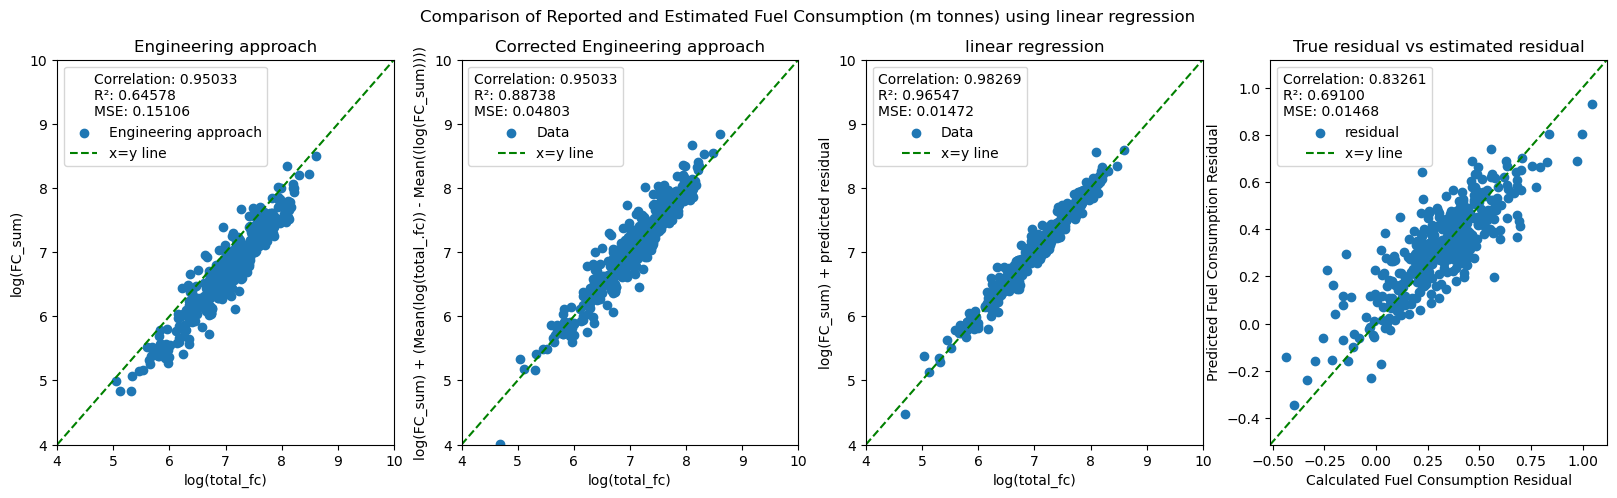

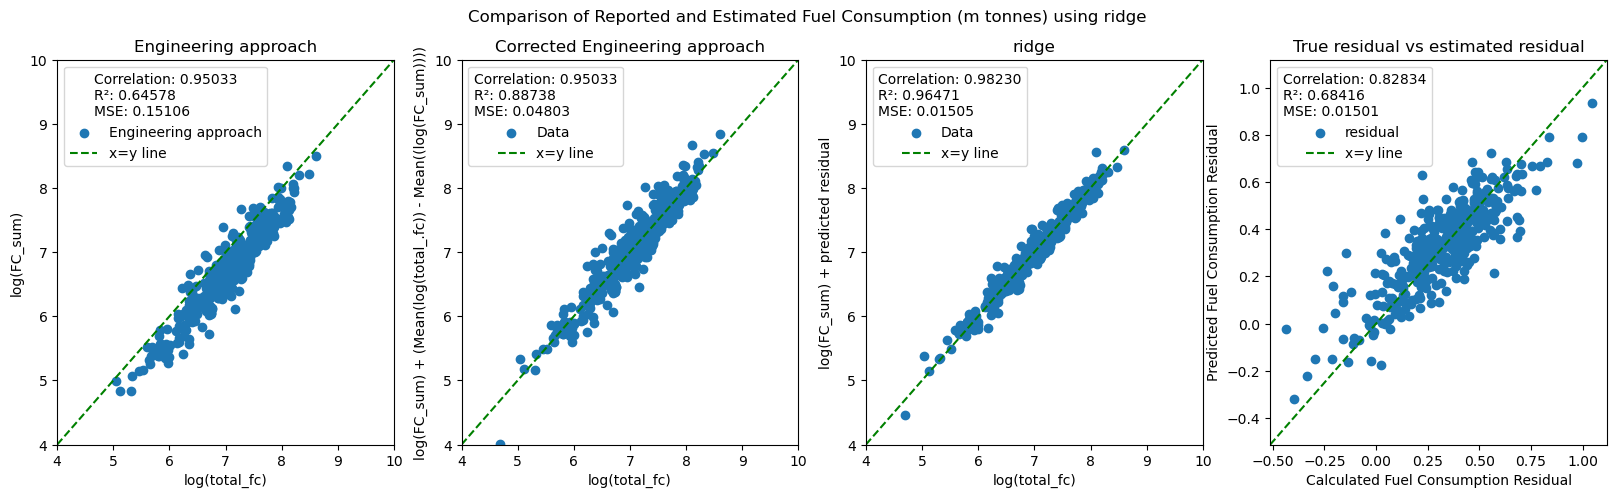

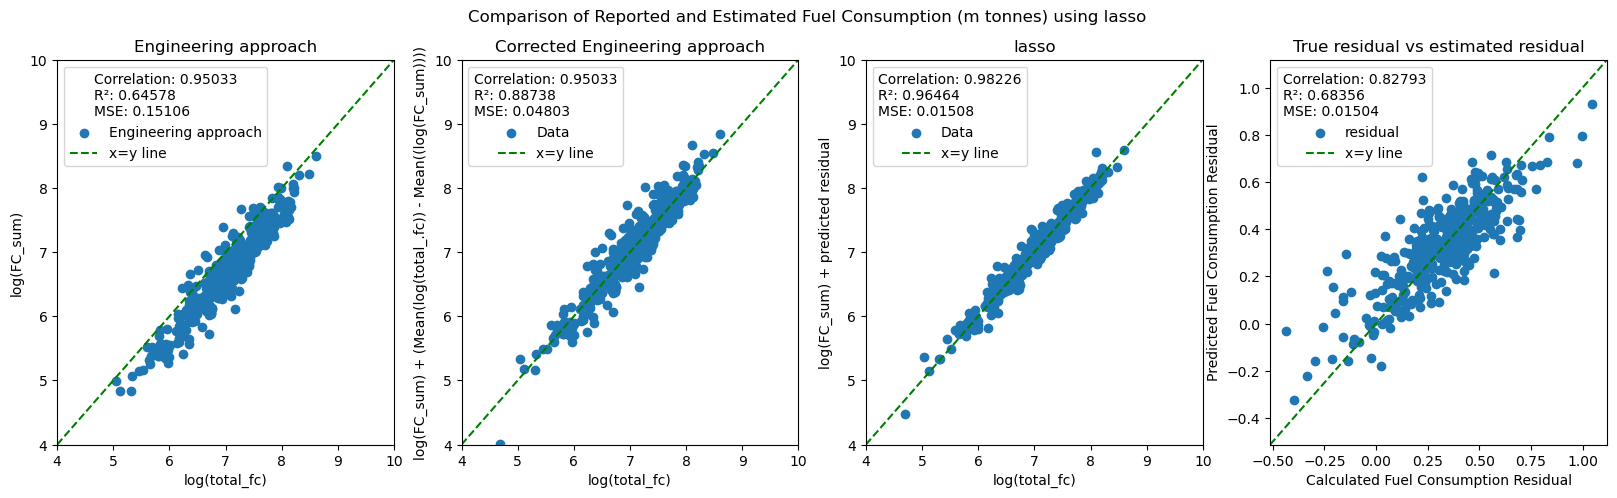

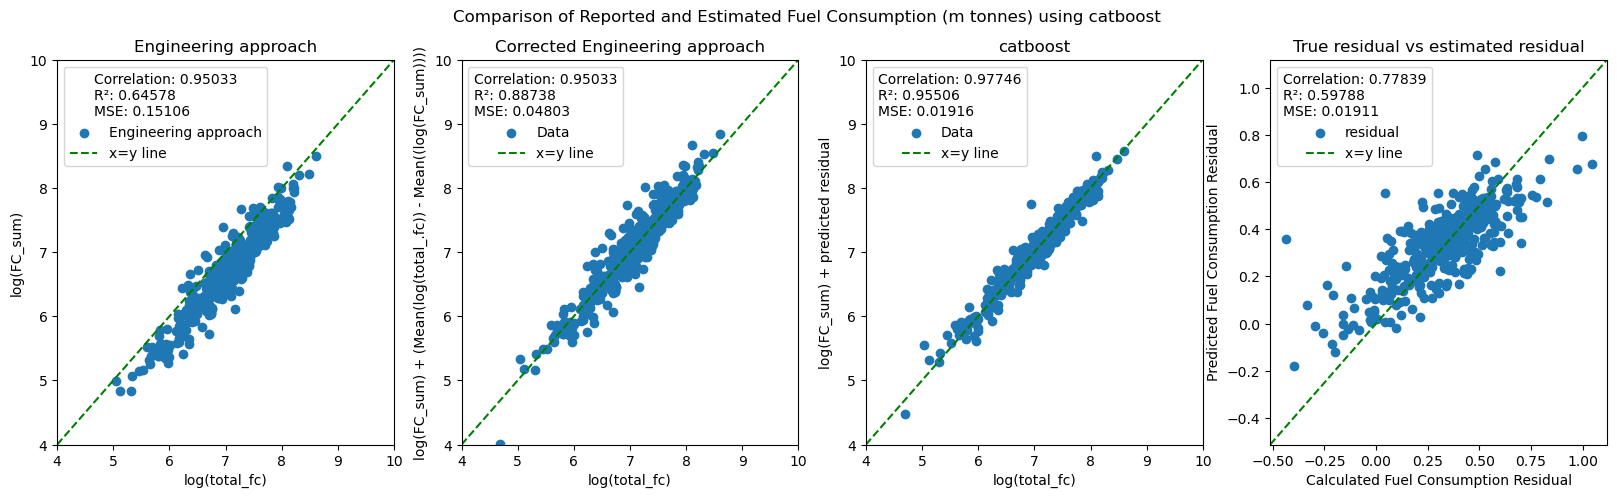

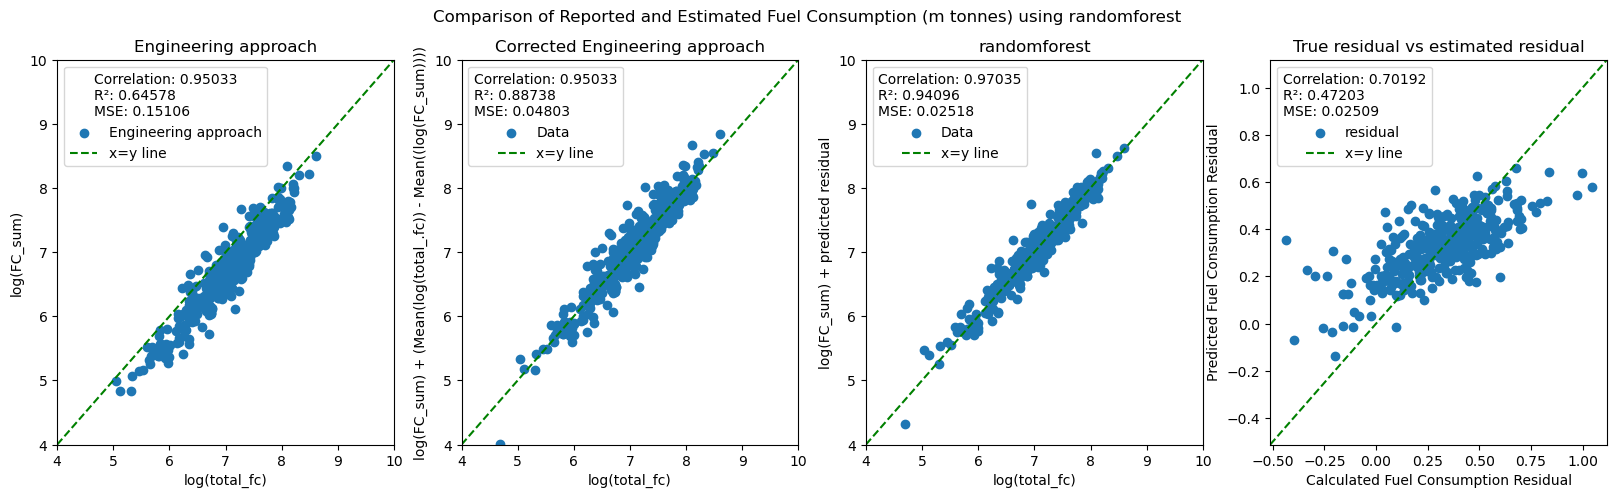

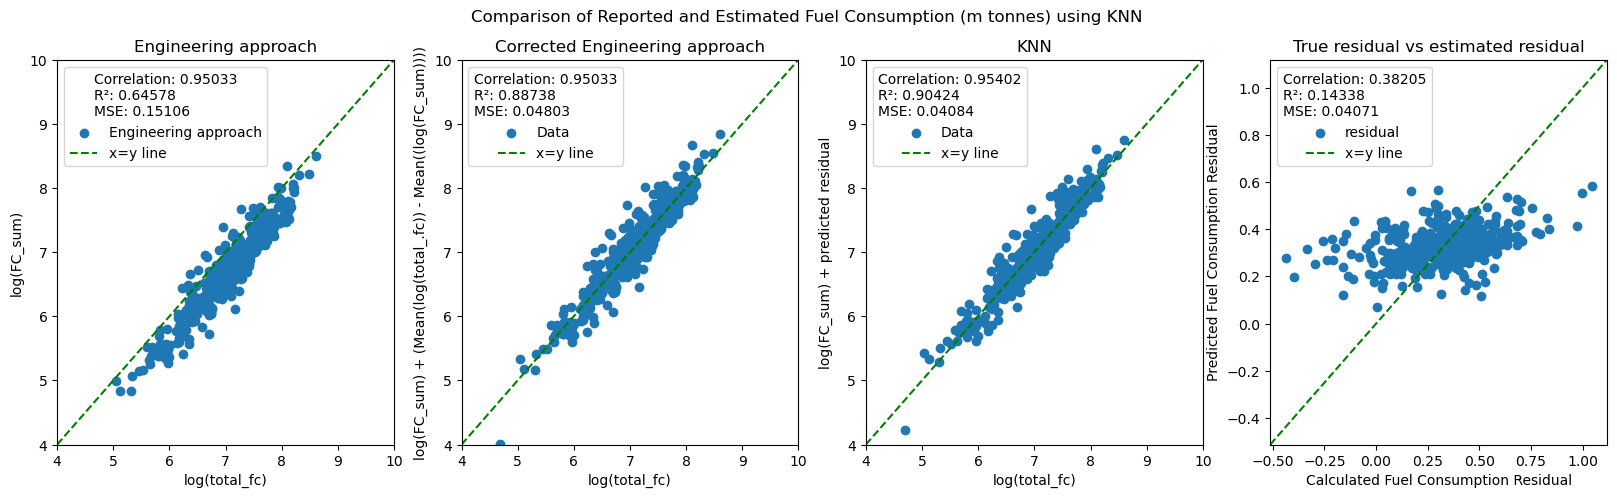

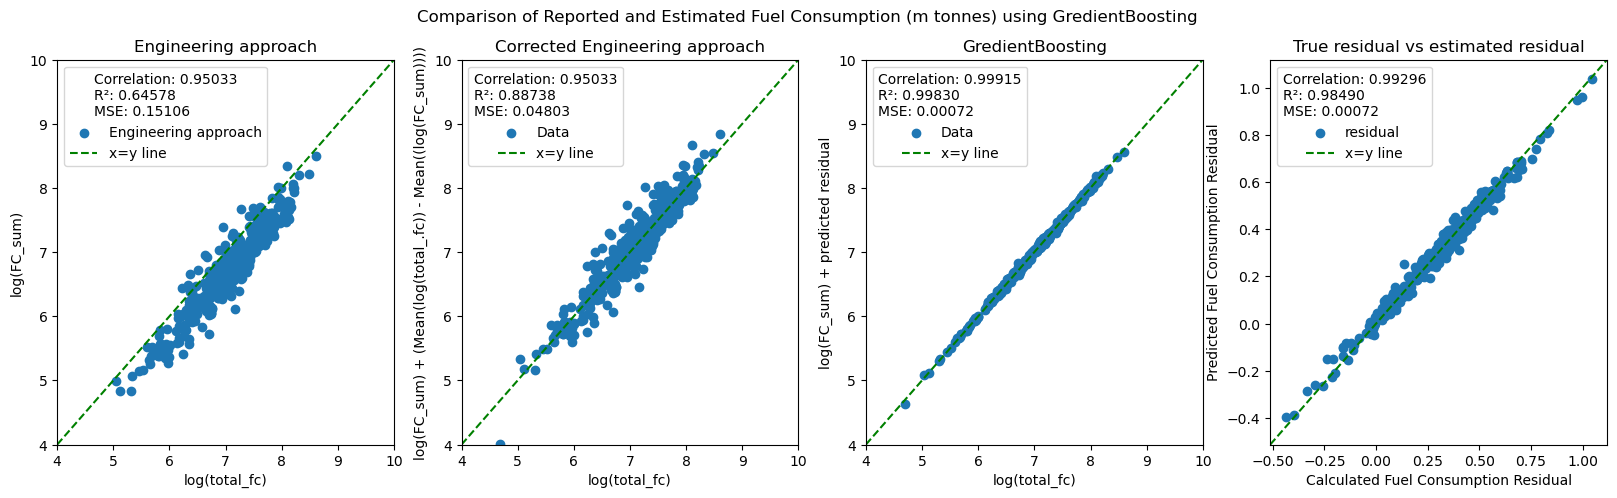

In [71]:
plot_test(models, df_ml, features, preprocessor_linear)

### Leave-One-Out Test for each model: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


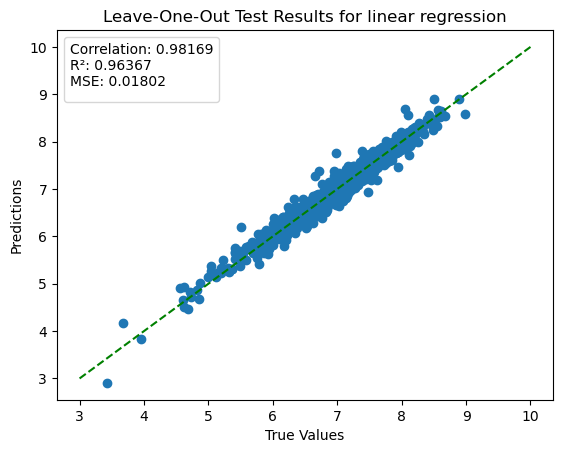

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


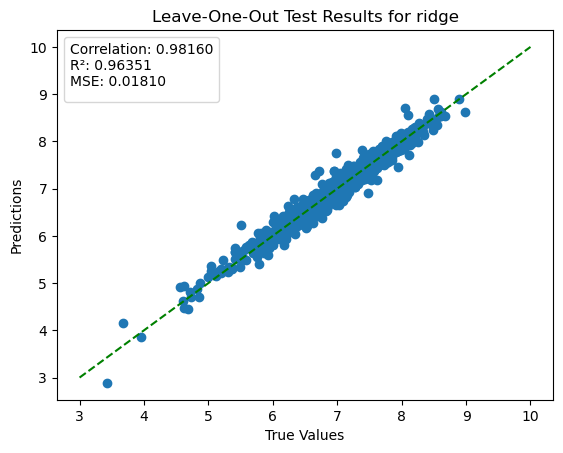

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


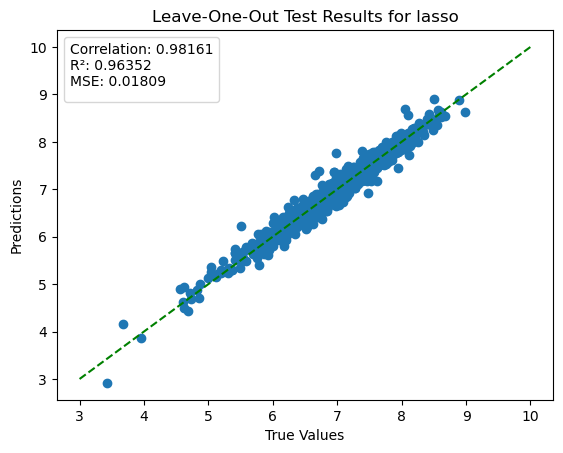

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


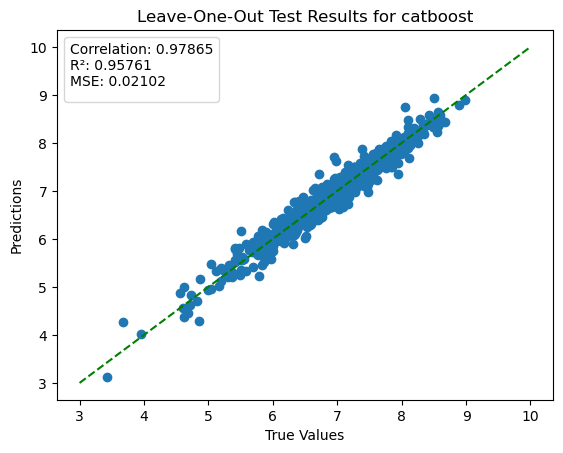

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


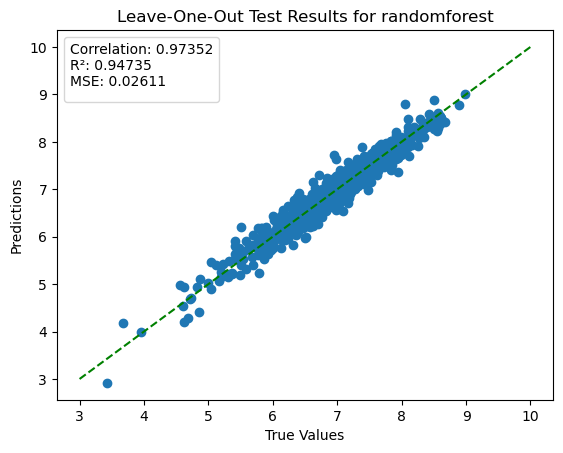

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


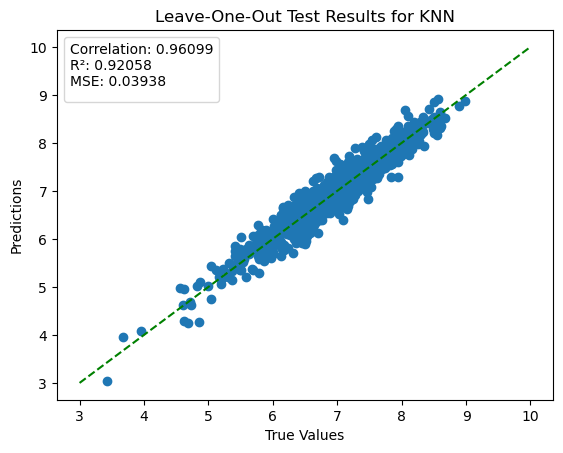

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


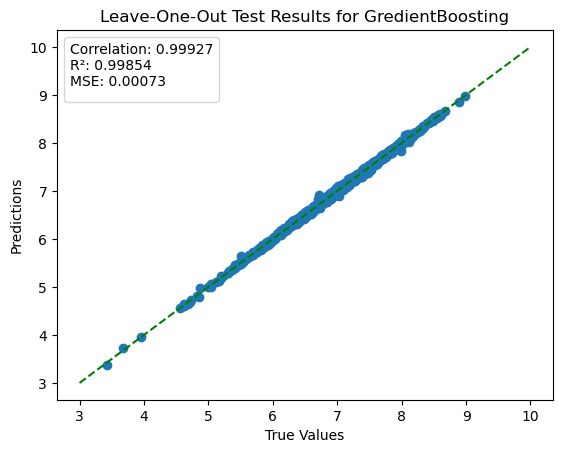

In [68]:
for model in models:
    pipe = make_pipeline(preprocessor_linear, models[model])
    FC_sum = df_ml['FC_sum'].values / 1000000
    total_fc = df_ml['total.fc'] 
    y = df_ml['residual']
    X = df_ml

    # Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    res_predictions = np.zeros(len(y))

    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        pipe.fit(X_train, y_train)

        # Predict on the test set
        y_pred = pipe.predict(X_test)

        res_predictions[test_index] = y_pred

    y_prediction = np.log(FC_sum) + res_predictions
    # Plotting the results
    # Calculate R-squared
    r_squared_mod = r2_score(np.log(total_fc), y_prediction)

    # Calculate correlation
    correlation_mod = np.corrcoef(np.log(total_fc), y_prediction)[0, 1]

    # Calculate mean squared error
    mse_mod = mean_squared_error(np.log(total_fc), y_prediction)
    legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod, r_squared_mod, mse_mod)
    plt.legend(title=legend_title)
    plt.scatter(np.log(total_fc), y_prediction, label='data')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Leave-One-Out Test Results for {model}')
    plt.plot([3, 10], [3, 10], 'g--', label='x=y line')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


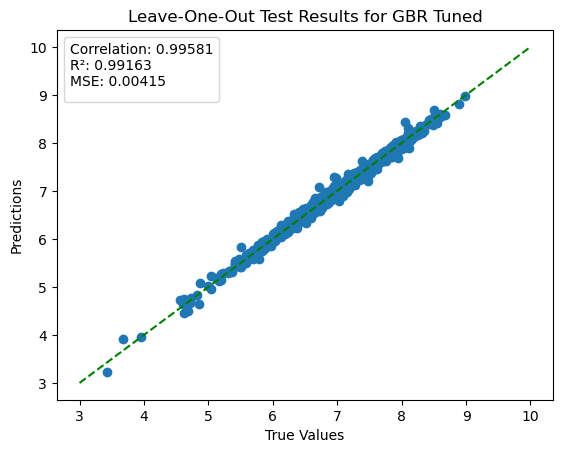

In [5]:
# Leave-One-Out Test for GredientBoostingRegressor after hyperparameter tuning mentioned in previous section:
model = GradientBoostingRegressor(n_estimators=3302, learning_rate=0.005, max_depth=9,
                                max_features=19, min_samples_leaf=16, loss='squared_error', subsample=0.7,
                                min_samples_split=102, warm_start=True)
pipe = make_pipeline(preprocessor_linear, model)
FC_sum = df_ml['FC_sum'].values / 1000000
total_fc = df_ml['total.fc'] 
y = df_ml['residual']
X = df_ml

# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
res_predictions = np.zeros(len(y))

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    pipe.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipe.predict(X_test)

    res_predictions[test_index] = y_pred

y_prediction = np.log(FC_sum) + res_predictions
# Plotting the results
# Calculate R-squared
r_squared_mod = r2_score(np.log(total_fc), y_prediction)

# Calculate correlation
correlation_mod = np.corrcoef(np.log(total_fc), y_prediction)[0, 1]

# Calculate mean squared error
mse_mod = mean_squared_error(np.log(total_fc), y_prediction)
legend_title = 'Correlation: {:.5f}\nR²: {:.5f}\nMSE: {:.5f}'.format(correlation_mod, r_squared_mod, mse_mod)
plt.legend(title=legend_title)
plt.scatter(np.log(total_fc), y_prediction, label='data')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Leave-One-Out Test Results for GBR Tuned')
plt.plot([3, 10], [3, 10], 'g--', label='x=y line')
plt.show()